<a href="https://colab.research.google.com/github/darkomike/ESSR/blob/main/ESSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models.vgg import VGG16_Weights
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset,TensorDataset
import os
import warnings
import urllib.error
import matplotlib.pyplot as plt
import numpy as np


In [44]:
class MultiScaleExtractor(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super(MultiScaleExtractor, self).__init__()
        # Simplified Swin Transformer blocks for three scales
        self.scale1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )
        self.scale2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 5, 1, 2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 5, 1, 2)
        )
        self.scale3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 7, 1, 3),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 7, 1, 3)
        )
        # Channel attention for feature fusion
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            # The in_channels of the Conv2d layer within the attention module
            # needs to be changed to out_channels*3 to match the number of channels
            # in the 'combined' tensor.
            nn.Conv2d(out_channels * 3, out_channels * 3, 1),
            nn.Sigmoid()
        )
        self.fusion = nn.Conv2d(out_channels * 3, out_channels, 1)

    def forward(self, x):
        s1 = self.scale1(x)
        s2 = self.scale2(x)
        s3 = self.scale3(x)
        combined = torch.cat([s1, s2, s3], dim=1)
        attn = self.attention(combined)
        combined = combined * attn
        return self.fusion(combined)


In [45]:
class PreprocessingModule(nn.Module):
    def __init__(self, channels=3):
        super(PreprocessingModule, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)
        self.filter = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        filtered = self.conv(x)
        return self.filter(filtered)


In [46]:
class ESSR(nn.Module):
    def __init__(self, upscale_factor=4):
        super(ESSR, self).__init__()
        self.preprocess = PreprocessingModule(channels=3)
        self.extractor = MultiScaleExtractor(in_channels=3, out_channels=64)
        # Simplified SR network (replace with SwinIR for production)
        self.sr_body = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1)
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 64 * upscale_factor ** 2, 3, 1, 1),
            nn.PixelShuffle(upscale_factor)
        )
        self.output = nn.Conv2d(64, 3, 3, 1, 1)
        # Discriminator for adversarial loss
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        x = self.preprocess(x)
        features = self.extractor(x)
        x = self.sr_body(features)
        x = self.upsample(x)
        return self.output(x)


In [47]:
# Hybrid Loss Function
class HybridLoss(nn.Module):
    def __init__(self, device):
        super(HybridLoss, self).__init__()
        self.l1_loss = nn.L1Loss()


        try:
            vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:16].eval().to(device)
            # Download VGG16 weights if not available locally
            for param in vgg.parameters():
                param.requires_grad = False
            self.vgg = vgg
        except urllib.error.URLError as e:
            # Fallback to local weights if available
            weights_path = os.path.expanduser("~/.cache/torch/hub/checkpoints/vgg16-397923af.pth")
            if os.path.exists(weights_path):
                vgg = vgg16(weights=None).features[:16].eval().to(device)
                vgg.load_state_dict(torch.load(weights_path))
                for param in vgg.parameters():
                    param.requires_grad = False
                self.vgg = vgg
                print(f"Loaded VGG16 weights from local cache: {weights_path}")
            else:
                warnings.warn(
                    f"Failed to download VGG16 weights due to network error: {e}\n"
                    f"No local weights found at {weights_path}\n"
                    "Please download 'vgg16-397923af.pth' from "
                    "https://download.pytorch.org/models/vgg16-397923af.pth and place it in "
                    f"{weights_path}, or ensure internet connectivity."
                )
                # Initialize VGG16 without pretrained weights as a last resort
                self.vgg = vgg16(weights=None).features[:16].eval().to(device)

        self.contrastive_loss = nn.CrossEntropyLoss()

    def perceptual_loss(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return self.l1_loss(sr_features, hr_features)

    def contrastive_loss_fn(self, features1, features2, batch_size):
        # Reshape features to 2D before matrix multiplication
        features1 = features1.view(batch_size, -1)  # Flatten spatial dimensions
        features2 = features2.view(batch_size, -1)  # Flatten spatial dimensions

        # Simplified InfoNCE loss
        logits = torch.matmul(features1, features2.t())
        labels = torch.arange(batch_size).to(logits.device)
        return self.contrastive_loss(logits, labels)


    def forward(self, sr, hr, features1, features2, batch_size, discriminator, real=True):
        l1 = self.l1_loss(sr, hr)
        perceptual = self.perceptual_loss(sr, hr)
        contrastive = self.contrastive_loss_fn(features1, features2, batch_size)
        adv = -torch.mean(discriminator(sr)) if real else torch.mean(discriminator(sr))
        return 1.0 * l1 + 0.1 * perceptual + 0.5 * contrastive + 0.01 * adv


In [48]:
# Training Loop
def train_essr(model, train_loader, epochs=200, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    loss_fn = HybridLoss(device).to(device)

    # Use mixed-precision training only if CUDA is available
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # Initialize an empty list to store losses for each epoch
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            optimizer.zero_grad()

            # Use autocast only if CUDA is available
            with torch.cuda.amp.autocast(enabled=use_amp):
                # Generate augmented views for contrastive loss
                lr_aug1 = torch.rot90(lr, 1, [2, 3])
                lr_aug2 = torch.rot90(lr, 2, [2, 3])
                sr = model(lr)
                features1 = model.extractor(lr_aug1)
                features2 = model.extractor(lr_aug2)
                loss = loss_fn(sr, hr, features1, features2, lr.size(0), model.discriminator)

            # Backpropagation with or without mixed precision
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

        # Calculate average loss for the epoch and store it in the list
        avg_epoch_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)

        print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss:.4f}')
    return epoch_losses


Using device: cuda


<ipython-input-48-65d8af1e3e13>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
<ipython-input-48-65d8af1e3e13>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1, Loss: 5.8781
Epoch 2, Loss: 4.7605
Epoch 3, Loss: 3.6885
Epoch 4, Loss: 3.1282
Epoch 5, Loss: 2.5053
Epoch 6, Loss: 1.9561
Epoch 7, Loss: 1.7036
Epoch 8, Loss: 1.5089
Epoch 9, Loss: 1.2578
Epoch 10, Loss: 1.1436


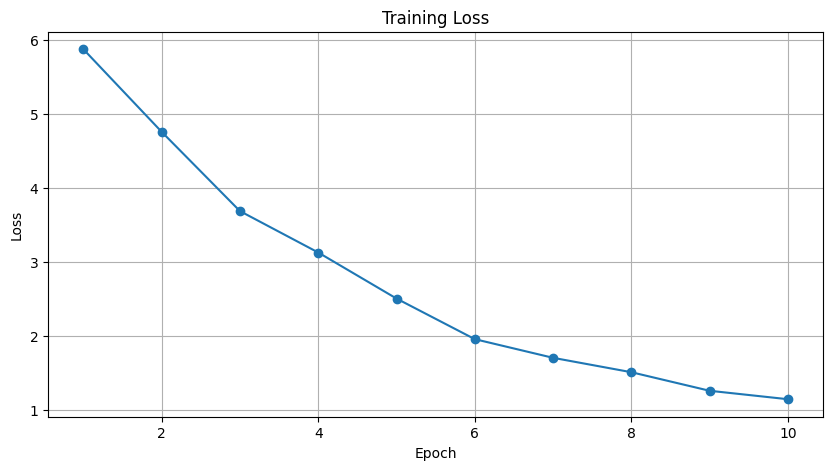

In [49]:
# Placeholder dataset (replace with SET5/DIV2K)

lr_data = torch.randn(100, 3, 64, 64)
hr_data = torch.randn(100, 3, 256, 256)
dataset = TensorDataset(lr_data, hr_data)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


epochs = 10
model = ESSR(upscale_factor=4)
epoch_losses =train_essr(model, train_loader, epochs=epochs)


# Plotting the loss curve
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.plot(np.arange(1, epochs + 1), epoch_losses, marker='o', linestyle='-')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()